In [1]:
import dask, concurrent.futures, time, warnings, os, re, pickle
from osgeo import gdal
import os
import requests as r
import pandas as pd
import geopandas as gpd
import numpy as np
import rasterio as rio
import rioxarray as riox
import time
import xarray as xr
from urllib.request import urlopen
from xml.etree.ElementTree import parse,fromstring
from pandas import to_datetime
from rasterio.crs import CRS
from datetime import datetime, timedelta
from netrc import netrc
from pyproj import Proj
from src.hls_funcs import fetch
from src.hls_funcs.masks import mask_hls, shp2mask, bolton_mask
from src.hls_funcs.indices import ndvi_func
from src.hls_funcs.smooth import smooth_xr, despike_ts_xr
import cartopy.crs as ccrs
from rasterio.plot import show
from src.hls_funcs.predict import pred_bm
import dask.diagnostics

In [2]:
t0 = time.time()
os.chdir('/project/cper_neon_aop/hls_cog/')

In [3]:
cper_f = os.path.join('data/ground/cper_pastures_2017_clip.shp')
mod_bm = pickle.load(open('src/models/CPER_HLS_to_VOR_biomass_model_lr_simp.pk', 'rb'))

In [ ]:
yr = 2021

In [4]:
cluster_loc = 'hpc'
t1 = time.time()
if cluster_loc == 'local':
    print('   setting up Local cluster...')
    from dask.distributed import LocalCluster, Client
    import dask
    aws=False
    fetch.setup_env(aws=aws)
    cluster = LocalCluster(n_workers=8, threads_per_worker=2)
    client = Client(cluster)
    display(client)
elif cluster_loc == 'coiled':
    import coiled
    aws=True
    fetch.setup_env(aws=aws)
    s3_cred = fetch.setup_netrc(creds=['spkearney', '1mrChamu'], aws=aws)
    coiled.create_software_environment(
    name="hls_cog_coiled",
    conda="hls_cog_coiled_env.yaml")
    cluster = coiled.Cluster(
        name="hls_cog_coiled",
        software="kearney-sp/hls_cog_coiled",
        n_workers=5,
        worker_cpu=2,
        scheduler_cpu=2,
        backend_options={"region": "us-west-2"},
        environ=dict(GDAL_DISABLE_READDIR_ON_OPEN='FALSE', 
                   #AWS_NO_SIGN_REQUEST='YES',
                   GDAL_MAX_RAW_BLOCK_CACHE_SIZE='200000000',
                   GDAL_SWATH_SIZE='200000000',
                   VSI_CURL_CACHE_SIZE='200000000',
                   CPL_VSIL_CURL_ALLOWED_EXTENSIONS='TIF',
                   GDAL_HTTP_UNSAFESSL='YES',
                   GDAL_HTTP_COOKIEFILE=os.path.expanduser('~/cookies.txt'),
                   GDAL_HTTP_COOKIEJAR=os.path.expanduser('~/cookies.txt'),
                   AWS_REGION='us-west-2',
                   AWS_SECRET_ACCESS_KEY=s3_cred['secretAccessKey'],
                   AWS_ACCESS_KEY_ID=s3_cred['accessKeyId'],
                   AWS_SESSION_TOKEN=s3_cred['sessionToken'])
    )
    client = Client(cluster)
    display(client)
elif cluster_loc == 'hpc':
    from dask.distributed import LocalCluster, Client
    import dask_jobqueue as jq
    import dask
    print('   setting up temporary Local cluster on HPC...')
    aws=False
    fetch.setup_env(aws=aws)
    dask.config.set({'distributed.dashboard.link': '/user/{USER}/proxy/{port}/status'})
    cluster = LocalCluster(n_workers=8, threads_per_worker=2)
    client = Client(cluster)
    display(client)
print('...completed in ' + str(round(time.time() - t1, 0)) + ' secs')
print('total elasped time: ' + str(round((time.time() - t0)/60, 2)) + ' mins\n')

/project/cper_neon_aop/conda_envs/hls_cog_env/lib/python3.9/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


   setting up temporary Local cluster on HPC...


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/sean.kearney/proxy/8787/status,
Dashboard: /user/sean.kearney/proxy/8787/status,Workers: 8
Total threads: 16,Total memory: 23.44 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:38316,Workers: 8
Dashboard: /user/sean.kearney/proxy/8787/status,Total threads: 16
Started: Just now,Total memory: 23.44 GiB
Comm: tcp://127.0.0.1:38666,Total threads: 2
Dashboard: /user/sean.kearney/proxy/45187/status,Memory: 2.93 GiB
Nanny: tcp://127.0.0.1:36517,


...completed in 3.0 secs
total elasped time: 0.05 mins



In [11]:
df_cper = gpd.read_file(cper_f)
df_cper = df_cper.dissolve(by='Past_Name_').reset_index().rename(columns={'Past_Name_': 'Pasture'})

bounds_latlon = list(df_cper.to_crs('EPSG:4236').total_bounds)
bounds_latlon

start_date = str(yr - 1) + "-11-01"
end_date = str(yr + 1) + "-03-01"

# set the date range for analysis
date_rng = pd.date_range(start=start_date, end=end_date)

print('   fetching data...')
t1 = time.time()
# fetch the COG data from the AWS bucket
data_dict = {'date_range': [str(date_rng.min().date()), str(date_rng.max().date())]}
hls_ds = fetch.get_hls(hls_data=data_dict,
                       bbox_latlon=bounds_latlon, 
                       lim=500,
                       aws=aws)
hls_ds = hls_ds.where(hls_ds['eo:cloud_cover'] != None, drop=True)
hls_ds = hls_ds.where(hls_ds['eo:cloud_cover'] < 90, drop=True)
#hls_ds = hls_ds.loc[dict(x=slice(517587.0, 527283.0), y=slice(4524402.0, 4514699.0))].chunk({'y': -1,
#                                                                                             'x': -1,
#                                                                                             'time':1})
hls_mask = mask_hls(hls_ds['FMASK'])
hls_ds = hls_ds.where(hls_mask == 0).load()
hls_ds['time'] = hls_ds['time'].dt.date
print('...completed in ' + str(round(time.time() - t1, 0)) + ' secs')
print('total elasped time: ' + str(round((time.time() - t0)/60, 2)) + ' mins\n')

   fetching data...
...completed in 679.0 secs
total elasped time: 13.79 mins



In [12]:
if cluster_loc == 'hpc':
    print('   closing local HPC cluster and scaling up to new cluster...')
    t1 = time.time()
    client.close()
    cluster.close()
    partition='brief-low',#'short','debug', 'mem', 'mem-low',
    num_processes = 4
    num_threads_per_processes = 2
    mem = 1.0*num_processes*num_threads_per_processes#*1.25
    n_cores_per_job = num_processes*num_threads_per_processes
    clust = jq.SLURMCluster(queue=partition,
                            processes=num_processes,
                            cores=n_cores_per_job,
                            memory=str(mem)+'GB',
                            interface='ib0',
                            #interface='enp24s0f0',
                            local_directory='$TMPDIR',
                            death_timeout=30,
                            walltime='02:00:00',
                            job_extra=["--output=/dev/null","--error=/dev/null"])
    client=Client(clust)
    #Scale Cluster 
    num_jobs=16
    clust.scale(jobs=num_jobs)
    client.wait_for_workers(n_workers=num_jobs*num_processes, timeout=60)
    display(client)
    #num_jobs=16
    #clust.scale(jobs=num_jobs)
    #client.wait_for_workers(n_workers=num_jobs*num_processes, timeout=60)
    print('...completed in ' + str(round(time.time() - t1, 0)) + ' secs')
    print('total elasped time: ' + str(round((time.time() - t0)/60, 2)) + ' mins\n')

print('   applying secondary cloud mask...')
hls_ds = hls_ds.chunk({'time': -1, 'y': 50, 'x': 50})
t1 = time.time()
hls_bolton_mask = bolton_mask(hls_ds)
hls_ds = hls_ds.where(hls_bolton_mask == 0).compute()
print('...completed in ' + str(round(time.time() - t1, 0)) + ' secs')
print('total elasped time: ' + str(round((time.time() - t0)/60, 2)) + ' mins\n')

print('   computing NDVI for available dates...')
hls_ds = hls_ds.chunk({'time': 20, 'y': 50, 'x': 50})
t1 = time.time()
# create ndvi array
xr_ndvi = ndvi_func(hls_ds).compute()
xr_ndvi.name = 'NDVI'
print('...completed in ' + str(round(time.time() - t1, 0)) + ' secs')
print('total elasped time: ' + str(round((time.time() - t0)/60, 2)) + ' mins\n')

print('   computing biomass for available dates...')
t1 = time.time()
# create biomass array
xr_bm = hls_ds.map_blocks(pred_bm, template=hls_ds['NIR1'],
                          kwargs=dict(model=mod_bm)).where(hls_ds['NIR1'].notnull()).compute()

xr_bm.name = 'Biomass'
print('...completed in ' + str(round(time.time() - t1, 0)) + ' secs')
print('total elasped time: ' + str(round((time.time() - t0)/60, 2)) + ' mins\n')

   closing local HPC cluster and scaling up to new cluster...


<Client: 'tcp://10.1.9.142:42956' processes=60 threads=120, memory=111.60 GiB>

...completed in 26.0 secs
total elasped time: 14.73 mins

   applying secondary cloud mask...
...completed in 44.0 secs
total elasped time: 15.47 mins

   computing NDVI for available dates...
...completed in 1.0 secs
total elasped time: 15.51 mins

   computing biomass for available dates...
...completed in 27.0 secs
total elasped time: 15.96 mins



In [13]:
print('   removing dates with > 75% cloud cover...')
t1 = time.time()
partial_mask = (xr_ndvi.count(dim=['y', 'x'])/np.product(xr_ndvi.shape[1:])) > 0.25
xr_ndvi = xr_ndvi.where(partial_mask, drop=True)
xr_bm = xr_bm.where(partial_mask, drop=True)
print('...completed in ' + str(round(time.time() - t1, 0)) + ' secs')
print('total elasped time: ' + str(round((time.time() - t0)/60, 2)) + ' mins\n')

   removing dates with > 75% cloud cover...
...completed in 0.0 secs
total elasped time: 16.78 mins



In [16]:
print('   creating daily template for output...')
t1 = time.time()
# create an output Dataset template with all dates
dat_out = xr.Dataset(coords={'y': hls_ds.y,
                             'x': hls_ds.x,
                             'time': date_rng}).chunk({'y': 5, 'x': 5, 'time':-1})

# assign the time coordinate to the output
dat_out['time'] = dat_out['time'].dt.date

# create empty arrays for filling variable values
dat_out = dat_out.assign(NDVI=(['time', 'y', 'x'],
                               np.zeros((dat_out.dims['time'], 
                                         dat_out.dims['y'], 
                                         dat_out.dims['x'])) * np.nan),
                         Biomass=(['time', 'y', 'x'],
                               np.zeros((dat_out.dims['time'], 
                                         dat_out.dims['y'], 
                                         dat_out.dims['x'])) * np.nan)
                         )

# combine the available NDVI data with the output Dataset template
dat_out_ds = xr.merge([xr_ndvi.groupby('time').mean(),
                       xr_bm.groupby('time').mean(), 
                       dat_out], compat='override').chunk({'y': 5, 'x': 5, 'time':-1})
dat_out_ds.attrs = hls_ds.attrs
dat_out_ds['NDVI_despike'] = despike_ts_xr(dat_out_ds['NDVI'].chunk({'y': 5, 'x': 5, 'time':-1}), 
                                           dat_thresh=0.07, 
                                           mask_outliers=False, 
                                           iters=2,
                                           dims=['time'])
dat_out_ds['NDVI_smooth'] = smooth_xr(dat_out_ds['NDVI_despike'], 
                                      dims=['time'], 
                                      kwargs={'double': True, 'limit': 91})
dat_out_ds['Biomass_despike'] = despike_ts_xr(dat_out_ds['Biomass'].chunk({'y': 5, 'x': 5, 'time':-1}),
                                              dat_thresh=150, 
                                              mask_outliers=False, 
                                              iters=2,
                                              dims=['time'])
dat_out_ds['Biomass_smooth'] = smooth_xr(dat_out_ds['Biomass_despike'], 
                                         dims=['time'],
                                         kwargs={'double': True, 'limit': 91})
print('...completed in ' + str(round(time.time() - t1, 0)) + ' secs')
print('total elasped time: ' + str(round((time.time() - t0)/60, 2)) + ' mins\n')

   creating daily template for output...
...completed in 2.0 secs
total elasped time: 17.37 mins



In [18]:
t1 = time.time()
print('   interpolating daily NDVI...')
dat_out_ds['NDVI_smooth'] = dat_out_ds['NDVI_smooth'].compute()
print('...completed in ' + str(round(time.time() - t1, 0)) + ' secs')
print('total elasped time: ' + str(round((time.time() - t0)/60, 2)) + ' mins\n')

   interpolating daily NDVI...
...completed in 96.0 secs
total elasped time: 19.22 mins



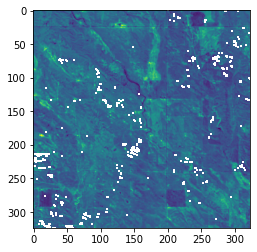

<AxesSubplot:>

In [19]:
show(dat_out_ds['NDVI_smooth'].isel(time=200), vmin=0.10, vmax=0.35)

In [20]:
t1 = time.time()
print('   interpolating daily biomass...')
dat_out_ds['Biomass_smooth'] = dat_out_ds['Biomass_smooth'].compute()
print('...completed in ' + str(round(time.time() - t1, 0)) + ' secs')
print('total elasped time: ' + str(round((time.time() - t0)/60, 2)) + ' mins\n')

   interpolating daily biomass...
...completed in 89.0 secs
total elasped time: 20.71 mins



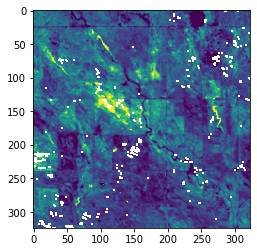

<AxesSubplot:>

In [21]:
show(dat_out_ds['Biomass_smooth'].isel(time=200), vmin=250, vmax=1000)

In [22]:
t1 = time.time()
print('   adding pasture data as a spatial coordinate...')
cper_info = df_cper[['Pasture', 'geometry']].reset_index(drop=True).reset_index().rename(columns={'index': 'id'})
past_dict = {row.id+1: row.Pasture for _, row in cper_info.iterrows()}
past_dict[0] = 'UNK'
cper_mask_shp = [(row.geometry, row.id+1) for _, row in cper_info.iterrows()]
cper_mask = shp2mask(shp=cper_mask_shp, 
                     transform=rio.Affine(30.0, 0.0, dat_out_ds.x.min(), 0.0, -30.0, dat_out_ds.y.max()), 
                     outshape=dat_out_ds['NDVI'].shape[1:], 
                     xr_object=dat_out_ds['NDVI'])
past_mask = np.array([past_dict[i] for i in cper_mask.values.flatten()]).reshape(cper_mask.shape)
dat_out_ds = dat_out_ds.assign(Pasture=(['y', 'x'], past_mask)).chunk({'y': 50, 'x': 50})
dat_out_ds = dat_out_ds.set_coords('Pasture')
print('...completed in ' + str(round(time.time() - t1, 0)) + ' secs')
print('total elasped time: ' + str(round((time.time() - t0)/60, 2)) + ' mins\n')

   adding pasture data as a spatial coordinate...
...completed in 1.0 secs
total elasped time: 21.41 mins



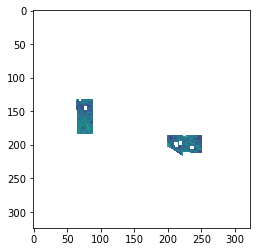

<AxesSubplot:>

In [23]:
show(dat_out_ds['NDVI_smooth'].isel(time=200).where(dat_out_ds['Pasture'].isin(['19N', '15E'])))

In [47]:
yr_mask = dat_out_ds['time'].astype(np.datetime64).dt.year == yr
dat_out_ds.sel(time=yr_mask)

<xarray.Dataset>
Dimensions:          (time: 365, x: 323, y: 324)
Coordinates:
  * time             (time) object 2021-01-01 2021-01-02 ... 2021-12-31
  * x                (x) float64 5.181e+05 5.181e+05 ... 5.277e+05 5.277e+05
  * y                (y) float64 4.525e+06 4.525e+06 ... 4.515e+06 4.515e+06
    epsg             int64 32613
    Pasture          (y, x) <U7 dask.array<chunksize=(50, 50), meta=np.ndarray>
Data variables:
    NDVI             (time, y, x) float64 dask.array<chunksize=(365, 50, 50), meta=np.ndarray>
    Biomass          (time, y, x) float64 dask.array<chunksize=(365, 50, 50), meta=np.ndarray>
    NDVI_despike     (time, y, x) float64 dask.array<chunksize=(365, 50, 50), meta=np.ndarray>
    NDVI_smooth      (time, y, x) float64 dask.array<chunksize=(365, 50, 50), meta=np.ndarray>
    Biomass_despike  (time, y, x) float64 dask.array<chunksize=(365, 50, 50), meta=np.ndarray>
    Biomass_smooth   (time, y, x) float64 dask.array<chunksize=(365, 50, 50), meta=np.ndarray>
Attributes:
    spec:        RasterSpec(epsg=32613, bounds=(518070, 4515390, 527760, 4525...
    crs:         epsg:32613
    transform:   | 30.00, 0.00, 518070.00|\n| 0.00,-30.00, 4525110.00|\n| 0.0...
    resolution:  30

In [76]:
dat_out_ds.sel(
    time=yr_mask)['NDVI_smooth'].astype('float32').rio.to_raster('output/hls_ndvi/cper_hls_ndvi_' + str(yr) + '.tif')
dat_out_ds.sel(
    time=yr_mask)['Biomass_smooth'].astype('int16').rio.to_raster('output/hls_biomass/cper_hls_bm_' + str(yr) + '.tif')

In [49]:
df_out_cper = dat_out_ds.sel(
    time=yr_mask).mean(dim=['y', 'x']).to_dataframe()

In [50]:
df_out_cper['Pasture'] = 'CPER'
df_out_cper = df_out_cper.drop(columns='epsg').reset_index()

In [51]:
df_out_pasts = dat_out_ds.sel(
    time=yr_mask).groupby('Pasture').mean(dim='stacked_y_x').to_dataframe()

In [52]:
df_out_pasts = df_out_pasts.drop(columns='epsg').reset_index()

In [81]:
df_out_all = pd.concat([df_out_cper, df_out_pasts])
df_out_all.rename(columns={'time': 'Date'}, inplace=True)

In [82]:
df_out_all.loc[:,
               [c for c in df_out_all.columns if 'NDVI' in c]] = df_out_all.loc[:,
                                                                                [c for c in df_out_all.columns if 'NDVI' in c]].apply(
    lambda x: round(x, 2))
df_out_all.loc[:,
               [c for c in df_out_all.columns if 'Biomass' in c]] = df_out_all.loc[:,
                                                                                [c for c in df_out_all.columns if 'Biomass' in c]].apply(
    lambda x: round(x, 0))

In [84]:
df_out_all[df_out_all['Pasture'] != 'UNK'].sort_values(
    ['Pasture', 'Date']).to_csv('output/cper_hls_means/cper_hls_means_' + str(yr) + '.csv', index=False)

In [85]:
cluster.close()
client.close()

Pasture
10S        AxesSubplot(0.125,0.125;0.775x0.755)
10SNE      AxesSubplot(0.125,0.125;0.775x0.755)
11NS       AxesSubplot(0.125,0.125;0.775x0.755)
11NW       AxesSubplot(0.125,0.125;0.775x0.755)
12C        AxesSubplot(0.125,0.125;0.775x0.755)
12NE       AxesSubplot(0.125,0.125;0.775x0.755)
12NW       AxesSubplot(0.125,0.125;0.775x0.755)
13E        AxesSubplot(0.125,0.125;0.775x0.755)
13W        AxesSubplot(0.125,0.125;0.775x0.755)
14         AxesSubplot(0.125,0.125;0.775x0.755)
15E        AxesSubplot(0.125,0.125;0.775x0.755)
15NWS      AxesSubplot(0.125,0.125;0.775x0.755)
15SW       AxesSubplot(0.125,0.125;0.775x0.755)
17N        AxesSubplot(0.125,0.125;0.775x0.755)
17S        AxesSubplot(0.125,0.125;0.775x0.755)
18N        AxesSubplot(0.125,0.125;0.775x0.755)
18S        AxesSubplot(0.125,0.125;0.775x0.755)
19N        AxesSubplot(0.125,0.125;0.775x0.755)
19S        AxesSubplot(0.125,0.125;0.775x0.755)
1E         AxesSubplot(0.125,0.125;0.775x0.755)
1W         AxesSubplot(0.125,0.1

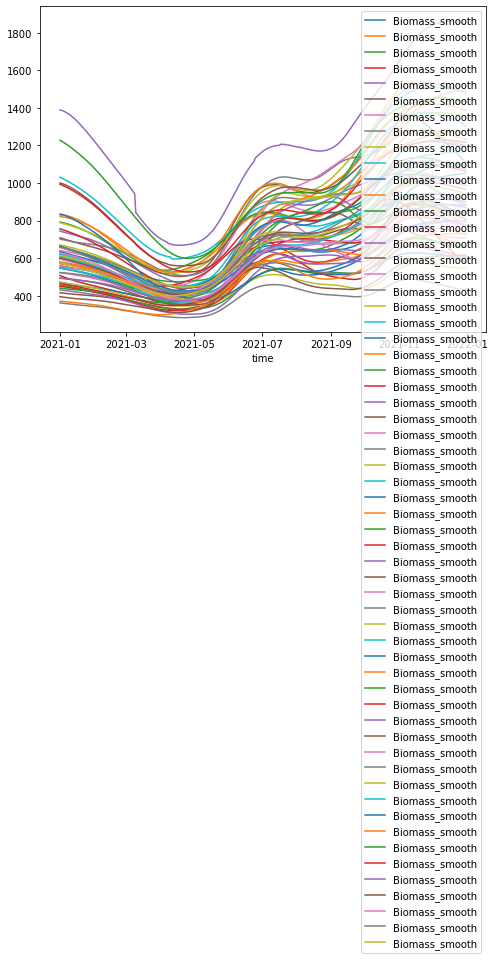

In [56]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(8,6))
df_out_all.groupby('Pasture').plot('time', 'Biomass_smooth', ax=ax)
#df_out_cper.drop(columns='epsg').reset_index().plot.scatter('time', 'Biomass', ax=ax1)
#ax1.set_ylim(0, 2000)

(0.0, 2000.0)

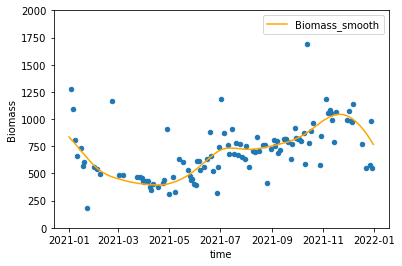

In [80]:
ax1 = df_out_cper.drop(columns='epsg').reset_index().plot('time', 'Biomass_smooth', c='orange')
df_out_cper.drop(columns='epsg').reset_index().plot.scatter('time', 'Biomass', ax=ax1)
ax1.set_ylim(0, 2000)

(0.0, 2000.0)

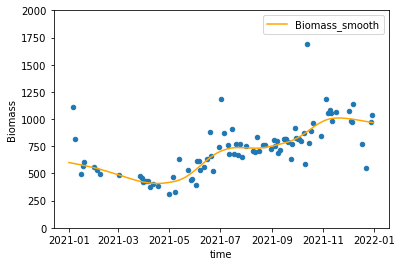

In [59]:
ax1 = df_out_cper.plot('time', 'Biomass_smooth', c='orange')
df_out_cper.plot.scatter('time', 'Biomass', ax=ax1)
ax1.set_ylim(0, 2000)

In [79]:
df_out_cper[df_out_cper['Biomass'] > 3000]

,epsg,NDVI,Biomass,NDVI_despike,NDVI_smooth,Biomass_despike,Biomass_smooth
time,,,,,,,
2021-02-20,32613,0.242879,3147.498762,0.210445,0.162022,3078.721519,473.058802
2021-11-03,32613,0.236271,3510.712521,0.236151,0.208766,2503.331723,994.769826
2021-12-12,32613,0.264317,16152.000000,0.264317,0.185077,16152.000000,963.334806


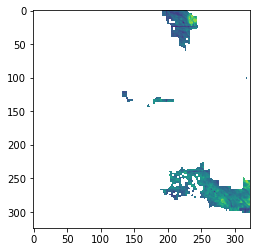

<AxesSubplot:>

In [46]:
show(dat_out_ds['NDVI'].sel(time=pd.to_datetime('2021-06-27').date()))

In [18]:
# check how long it takes to load the NDVI time series into memory
%%time
ndvi_test = ndvi_ds.load()

CPU times: user 1min 1s, sys: 5.67 s, total: 1min 6s
Wall time: 10min 15s


In [50]:
ndvi_test = ndvi_test.chunk({'y': 50, 'x': 50, 'time':-1})

In [55]:
# create an output Dataset template with all dates
dat_out = xr.Dataset(coords={'y': ndvi_test.y,
                             'x': ndvi_test.x,
                             'time': date_rng}).chunk({'y': 50, 'x': 50, 'time':-1})

# assign the time coordinate to the output
dat_out['time'] = dat_out['time'].dt.date

# create an empty array for filling NDVI values
dat_out = dat_out.assign(NDVI=(['y', 'x', 'time'],
                               np.zeros((dat_out.dims['y'], dat_out.dims['x'], dat_out.dims['time'])) * np.nan)
                         )

In [56]:
# combine the available NDVI data with the output Dataset template
dat_out_test = xr.merge([ndvi_test, dat_out], compat='override')
dat_out_test

/home/spkearney/miniconda3/envs/hls_cog2_env/lib/python3.9/site-packages/pandas/core/indexes/base.py:345: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  joined_ndarray, lidx, ridx = libjoin.outer_join_indexer(sv, ov)
/home/spkearney/miniconda3/envs/hls_cog2_env/lib/python3.9/site-packages/pandas/core/indexes/base.py:3512: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  indexer = self._engine.get_indexer(target._get_engine_target())


<xarray.Dataset>
Dimensions:         (time: 245, x: 324, y: 324)
Coordinates:
  * time            (time) object 2021-03-01 2021-03-02T10:02:36 ... 2021-10-31
    id              (time) object dask.array<chunksize=(245,), meta=np.ndarray>
  * x               (x) float64 5.176e+05 5.176e+05 ... 5.272e+05 5.273e+05
  * y               (y) float64 4.524e+06 4.524e+06 ... 4.515e+06 4.515e+06
    eo:cloud_cover  (time) float64 dask.array<chunksize=(245,), meta=np.ndarray>
    epsg            int64 32613
    Pasture         (y, x) <U7 dask.array<chunksize=(50, 50), meta=np.ndarray>
Data variables:
    NDVI            (time, y, x) float64 dask.array<chunksize=(245, 50, 50), meta=np.ndarray>
Attributes:
    spec:        RasterSpec(epsg=32613, bounds=(499950, 4489410, 611460, 4600...
    crs:         epsg:32613
    transform:   | 30.00, 0.00, 499950.00|\n| 0.00,-30.00, 4600860.00|\n| 0.0...
    resolution:  30

In [58]:
dat_out_test['NDVI_despike'] = despike_ts_xr(dat_out_test['NDVI'], dat_thresh=0.07, dims=['time'])
dat_out_test['NDVI_smooth'] = smooth_xr(dat_out_test['NDVI_despike'], dims=['time'], double=True)

In [65]:
%%time
# check how long it takes to run smooth for entire scene
ndvi_sm_test = dat_out_test['NDVI_smooth'].compute()

CPU times: user 35.2 s, sys: 2.59 s, total: 37.8 s
Wall time: 3min 58s


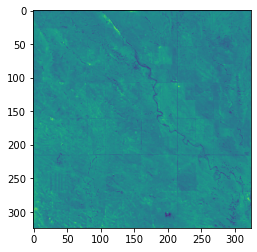

<AxesSubplot:>

In [66]:
show(ndvi_sm_test.isel(dict(time=20)))

In [60]:
%%time
# check how long it takes to run smooth on a single pasture
ndvi_sm_past_test = dat_out_test.chunk({'y': 15, 'x': 15, 'time':-1})['NDVI_smooth'].where(
    ndvi_test['Pasture'].isin(['19N'])).compute()

CPU times: user 47.6 s, sys: 3.33 s, total: 50.9 s
Wall time: 4min 15s


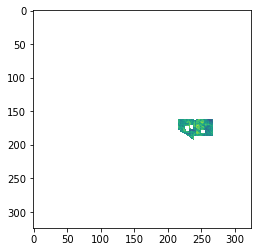

<AxesSubplot:>

In [61]:
show(ndvi_sm_past_test.isel(dict(time=20)))

In [62]:
df_ndvi_sm_past_test = ndvi_sm_past_test.mean(dim=['y', 'x']).to_dataframe()

/home/spkearney/miniconda3/envs/hls_cog2_env/lib/python3.9/site-packages/pandas/core/indexes/base.py:1963: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  return self._engine.is_monotonic_increasing


<AxesSubplot:xlabel='time'>

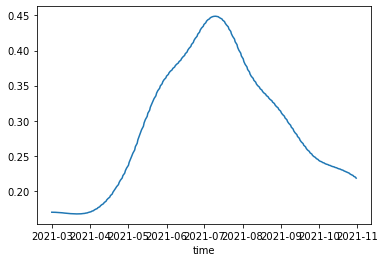

In [64]:
df_ndvi_sm_past_test['NDVI_smooth'].plot()

In [81]:
from src.hls_funcs.predict import pred_bm
mod_bm = pickle.load(open('src/models/CPER_HLS_to_VOR_biomass_model_lr_simp.pk', 'rb'))
hls_ds = hls_ds.chunk({'y': 50,
                      'x': 50, 
                      'time':1})
# convert to dataset and show
bm_ds = hls_ds.map_blocks(pred_bm, template=hls_ds['BLUE'],
                                             kwargs=dict(model=mod_bm)).to_dataset(name='Biomass')
bm_ds.attrs = hls_ds.attrs
bm_ds

<xarray.Dataset>
Dimensions:         (time: 89, y: 324, x: 324)
Coordinates:
  * time            (time) datetime64[ns] 2021-03-02T10:02:36 ... 2021-10-30T...
  * y               (y) float64 4.524e+06 4.524e+06 ... 4.515e+06 4.515e+06
  * x               (x) float64 5.176e+05 5.176e+05 ... 5.272e+05 5.273e+05
    id              (time) <U34 dask.array<chunksize=(1,), meta=np.ndarray>
    eo:cloud_cover  (time) int64 dask.array<chunksize=(1,), meta=np.ndarray>
    epsg            int64 dask.array<chunksize=(), meta=np.ndarray>
Data variables:
    Biomass         (time, y, x) float64 dask.array<chunksize=(1, 10, 10), meta=np.ndarray>
Attributes:
    spec:        RasterSpec(epsg=32613, bounds=(499950, 4489410, 611460, 4600...
    crs:         epsg:32613
    transform:   | 30.00, 0.00, 499950.00|\n| 0.00,-30.00, 4600860.00|\n| 0.0...
    resolution:  30

In [82]:
%%time
bm_ds_test = bm_ds.isel(time=10).compute()

CPU times: user 20.7 s, sys: 1.53 s, total: 22.2 s
Wall time: 58.1 s


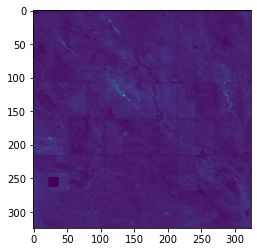

<AxesSubplot:>

In [83]:
show(bm_ds_test['Biomass'])

In [64]:
# get the percent of pasture pixels that are valid for each date
ndvi_test = ndvi_test.assign(pct_valid=(['Pasture', 'time'], 
                                               (ndvi_test['NDVI'].groupby('Pasture').count(dim=['stacked_y_x']) / 
                                                ndvi_test.groupby('Pasture').map(lambda x: x['stacked_y_x'].count()) * 100).transpose().data))
ndvi_test

<xarray.Dataset>
Dimensions:         (time: 89, y: 324, x: 324, Pasture: 58)
Coordinates:
  * time            (time) object 2021-03-02 2021-03-07 ... 2021-10-30
    id              (time) <U34 'HLS.S30.T13TEF.2021061T175241.v2.0' ... 'HLS...
  * x               (x) float64 5.176e+05 5.176e+05 ... 5.272e+05 5.273e+05
  * y               (y) float64 4.524e+06 4.524e+06 ... 4.515e+06 4.515e+06
    eo:cloud_cover  (time) int64 0 56 99 62 0 35 15 36 ... 11 26 2 21 90 15 22
    epsg            int64 32613
    Pasture         (y, x) <U7 'UNK' 'UNK' 'UNK' 'UNK' ... 'UNK' 'UNK' 'UNK'
Data variables:
    NDVI            (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan
    pct_valid       (Pasture, time) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
Attributes:
    spec:        RasterSpec(epsg=32613, bounds=(499950, 4489410, 611460, 4600...
    crs:         epsg:32613
    transform:   | 30.00, 0.00, 499950.00|\n| 0.00,-30.00, 4600860.00|\n| 0.0...
    resolution:  30

In [65]:
# rechunk the data
ndvi_test = ndvi_test.chunk({'y': 50, 'x': 50, 'time':-1})

In [66]:
# create an output Dataset template with all dates
dat_out = xr.Dataset(coords={'time': date_rng,
                             'y': ndvi_test.y,
                             'x': ndvi_test.x}).chunk({'time': -1, 'y': 50, 'x': 50})

# assign the time coordinate to the output
dat_out['time'] = dat_out['time'].dt.date

# create an empty array for filling NDVI values
dat_out = dat_out.assign(NDVI=(['time', 'y', 'x'],
                               np.zeros((dat_out.dims['time'], dat_out.dims['y'], dat_out.dims['x'])) * np.nan)
                         )

In [67]:
# combine the available NDVI data with the output Dataset template
test3 = xr.merge([ndvi_test, dat_out], compat='override')
test3

<xarray.Dataset>
Dimensions:         (time: 245, y: 324, x: 324, Pasture: 58)
Coordinates:
  * time            (time) object 2021-03-01 2021-03-02 ... 2021-10-31
    id              (time) object dask.array<chunksize=(245,), meta=np.ndarray>
  * x               (x) float64 5.176e+05 5.176e+05 ... 5.272e+05 5.273e+05
  * y               (y) float64 4.524e+06 4.524e+06 ... 4.515e+06 4.515e+06
    eo:cloud_cover  (time) float64 dask.array<chunksize=(245,), meta=np.ndarray>
    epsg            int64 32613
    Pasture         (y, x) <U7 dask.array<chunksize=(50, 50), meta=np.ndarray>
Data variables:
    NDVI            (time, y, x) float64 dask.array<chunksize=(245, 50, 50), meta=np.ndarray>
    pct_valid       (Pasture, time) float64 dask.array<chunksize=(58, 245), meta=np.ndarray>
Attributes:
    spec:        RasterSpec(epsg=32613, bounds=(499950, 4489410, 611460, 4600...
    crs:         epsg:32613
    transform:   | 30.00, 0.00, 499950.00|\n| 0.00,-30.00, 4600860.00|\n| 0.0...
    resolution:  30

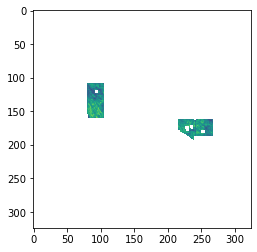

<AxesSubplot:>

In [82]:
# plot some valid data as a sanity check
show(test3['NDVI'].sel(time=test3['pct_valid'].mean(axis=0).idxmax().values).data)

In [83]:
test3['NDVI_despike'] = despike_ts_xr(test3['NDVI'], dat_thresh=0.07, dims=['time'])
test3['NDVI_smooth'] = smooth_xr(test3['NDVI_despike'], dims=['time'], double=True)

In [84]:
test_ds_mean = test3['NDVI_despike'].mean().compute()

KilledWorker: ("('array-2d0a4a874f2d3c45c1baa80bf58d6c4e', 0, 0, 0)", <WorkerState 'tls://10.6.12.39:39945', name: coiled-dask-kearney58-96076-worker-2ef929811d, status: closed, memory: 0, processing: 48>)

distributed.client - ERROR - Failed to reconnect to scheduler after 30.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
asyncio.exceptions.CancelledError
distributed.deploy.cluster - WARNING - Failed to sync cluster info multiple times - perhaps there's a connection issue? Error:
Traceback (most recent call last):
  File "/home/spkearney/miniconda3/envs/hls_cog2_env/lib/python3.9/site-packages/distributed/comm/tcp.py", line 398, in connect
    stream = await self.client.connect(
  File "/home/spkearney/miniconda3/envs/hls_cog2_env/lib/python3.9/site-packages/tornado/tcpclient.py", line 275, in connect
    af, addr, stream = await connector.start(connect_timeout=timeout)
asyncio.exceptions.CancelledError

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/spkearney/miniconda3/envs/hls_cog2_env/lib/python3.9/asyncio/tasks.py", line 492

In [26]:
#test1['pct_valid'] = test3['pct_valid']
test = test1.to_dataframe()

KilledWorker: ("('vectorize_despike_ts-vectorize_despike_ts_0-transpose-defa7063c3cf3034f5b143a5c7622497', 0, 1, 0)", <WorkerState 'tls://10.6.2.181:36807', name: coiled-dask-kearney58-96059-worker-cc782dd099, status: closed, memory: 0, processing: 49>)

In [21]:
test2 = test.reset_index(drop=False)[test.reset_index(drop=False)['Pasture'].isin(['19N', '15E'])]

In [22]:
test2.head()

,Pasture,time,NDVI,id,eo:cloud_cover,epsg,NDVI_despike,NDVI_smooth,pct_valid
2450,15E,2021-03-01,NaN,NaN,NaN,32613,NaN,0.170060,NaN
2451,15E,2021-03-02,0.168695,HLS.S30.T13TEF.2021061T175241.v2.0,0.0,32613,0.168695,0.170048,100.0
2452,15E,2021-03-03,NaN,NaN,NaN,32613,NaN,0.169909,NaN
2453,15E,2021-03-04,NaN,NaN,NaN,32613,NaN,0.169734,NaN
2454,15E,2021-03-05,NaN,NaN,NaN,32613,NaN,0.169572,NaN


<AxesSubplot:xlabel='time', ylabel='NDVI_despike'>

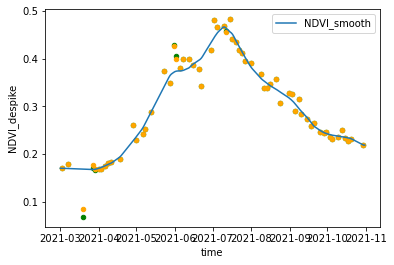

distributed.worker - WARNING - Heartbeat to scheduler failed
Traceback (most recent call last):
  File "/home/spkearney/miniconda3/envs/hls_cog2_env/lib/python3.9/site-packages/tornado/iostream.py", line 971, in _handle_write
    num_bytes = self.write_to_fd(self._write_buffer.peek(size))
  File "/home/spkearney/miniconda3/envs/hls_cog2_env/lib/python3.9/site-packages/tornado/iostream.py", line 1148, in write_to_fd
    return self.socket.send(data)  # type: ignore
TimeoutError: [Errno 110] Connection timed out

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/spkearney/miniconda3/envs/hls_cog2_env/lib/python3.9/site-packages/distributed/worker.py", line 1190, in heartbeat
    response = await retry_operation(
  File "/home/spkearney/miniconda3/envs/hls_cog2_env/lib/python3.9/site-packages/distributed/utils_comm.py", line 385, in retry_operation
    return await retry(
  File "/home/spkearney/miniconda3/envs/hls_cog2_

In [23]:
ax=test2[test2['Pasture']=='19N'].plot.scatter(x='time', y='NDVI', c='green')
ax=test2[test2['Pasture']=='19N'].plot.scatter(x='time', y='NDVI_despike', c='orange', ax=ax)
test2[test2['Pasture']=='19N'].plot(x='time', y='NDVI_smooth', ax=ax)

In [74]:
from src.hls_funcs.smooth import despike_ts, double_savgol
test2['NDVI_smooth2'] = test2.groupby('Pasture')['NDVI'].apply(double_savgol, double=False, window1_min=5, window2=5)

In [58]:
ndvi_despike = despike_ts_xr(ndvi_test, dat_thresh=0.1, dims=['time'])
ndvi_sm = smooth_xr(ndvi_despike, dims=['time'], double=True, kwargs={'window1_min':5, 'window2': 5})

ModuleNotFoundError: No module named 'seaborn'

In [46]:
ndvi_test.mean(dim=['x', 'y']).values

array([0.16875508, 0.17463448, 0.18003539, 0.18326259,        nan,
              nan, 0.18872243,        nan,        nan, 0.26117325,
       0.22882797, 0.24263185, 0.25242543, 0.28867242, 0.36582979,
              nan, 0.37327333,        nan, 0.34813588, 0.42817396])

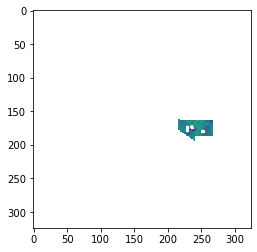

<AxesSubplot:>

In [32]:
show(ndvi_test.isel(time=2))

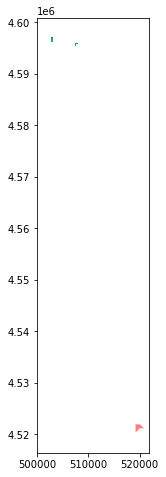

In [20]:
import matplotlib.pyplot as plt
#from descartes import PolygonPatch
fig, ax = plt.subplots(figsize=(12, 8))
show(ndvi_test['NDVI'].isel(time=3), transform=ndvi_ds.attrs['transform'], ax=ax)
#ax = mpl.pyplot.gca()
xs, ys = cper_mask_shp[0][0].exterior.xy
ax.fill(xs, ys, alpha=0.5, fc='r', ec='none')

In [8]:
np.unique(ndvi_ds['Pasture'].values)

array(['10S', '10SNE', '11NS', '11NW', '12C', '12NE', '12NW', '13E',
       '13W', '14', '15E', '15NWS', '15SW', '17N', '17S', '18N', '18S',
       '19N', '19S', '1E', '1W', '20NW', '20SE', '21N', '21S', '21SW',
       '22E', '22W', '23E', '23W', '24E', '24Strip', '24W', '25NW',
       '25SE', '26E', '26W', '28N', '29-30', '30NW', '30SW', '31E', '31W',
       '32W', '5E', '5W', '6EE', '6EW', '7NW', '7SE', '8E', '8NW', '8SE',
       '8SW', 'CN', 'HQ', 'Slayton', 'UNK'], dtype='<U7')

In [50]:
ndvi_ds.rio.transform()

Affine(30.0, 0.0, 517575.0,
       0.0, -30.0, 4524405.0)

In [8]:
data_dict = {'date_range': [str(datetime(2021, 3, 1).date()), str(datetime(2021, 10, 30).date())]}
tmp_data = fetch.get_hls(['spkearney', '1mrChamu'], hls_data=data_dict, aws=True)
da = tmp_data.loc[dict(x=slice(517587.0, 527283.0), y=slice(4524402.0, 4514699.0))]
da_mask = mask_hls(da['FMASK'])
da = da.where(da_mask == 0)

In [10]:
ndvi = ndvi_func(da)
ndvi_ts = ndvi.mean(dim=['y', 'x'])
ndvi_ts.values
#show(ndvi.values)

array([0.16473306, 0.16378575,        nan,        nan, 0.0634091 ,
       0.00390197, 0.11879054, 0.16833161, 0.15954587, 0.15991301,
       0.16094027, 0.16725394, 0.17561154, 0.17685513,        nan,
              nan, 0.18337277, 0.19368803,        nan, 0.27445619,
       0.2253724 , 0.24056128, 0.24424153, 0.2877616 , 0.36418753,
              nan, 0.33788244, 0.34569757, 0.33123684, 0.40755053,
       0.37426155, 0.36762935, 0.38202716,        nan, 0.38124757,
       0.37398769,        nan, 0.36399018, 0.33478624,        nan,
       0.43606091])

In [13]:
ndvi_ts.to_pandas().to_csv('ndvi_ts_test.csv')

In [14]:
coiled.list_clusters()

{}

distributed.client - ERROR - Failed to reconnect to scheduler after 30.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
asyncio.exceptions.CancelledError


In [16]:
#coiled.delete_cluster(name='hls_cog_coiled')  # Add your cluster name here
client.close()  # Close the client as well

distributed.deploy.cluster - WARNING - Failed to sync cluster info multiple times - perhaps there's a connection issue? Error:
Traceback (most recent call last):
  File "/home/spkearney/miniconda3/envs/hls_cog2_env/lib/python3.9/site-packages/distributed/comm/tcp.py", line 398, in connect
    stream = await self.client.connect(
  File "/home/spkearney/miniconda3/envs/hls_cog2_env/lib/python3.9/site-packages/tornado/tcpclient.py", line 275, in connect
    af, addr, stream = await connector.start(connect_timeout=timeout)
asyncio.exceptions.CancelledError

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/spkearney/miniconda3/envs/hls_cog2_env/lib/python3.9/asyncio/tasks.py", line 492, in wait_for
    fut.result()
asyncio.exceptions.CancelledError

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/spkearney/miniconda3/envs/hls_cog2_env/lib/python3.9/site

In [4]:
#%%time
#items = pystac_client.Client.open(
#    "https://earth-search.aws.element84.com/v0"
#).search(
#    intersects=dict(type="Point", coordinates=[-106, 35.7]),
#    collections=["sentinel-s2-l2a-cogs"],
#    datetime="2019-01-01/2020-01-01",
#    limit=10_000,
#).get_all_items()
#len(items)

In [6]:
from src.hls_funcs import fetch
